### Set up

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getcwd()

### Data

In [3]:
train_data = pd.read_csv(f'{data_dir}/data/train.csv' , index_col = 'new_ids')
test_data = pd.read_csv(f'{data_dir}/data/test.csv' , index_col = 'new_ids')

train_data['defective'] = train_data['defective'].apply(lambda x : 1 if x=='yes' else 0)

In [4]:
print( 'Train data', train_data.shape)
print( 'Test data', test_data.shape)

Train data (50000, 40)
Test data (5083, 39)


In [5]:
train_data.head(3)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,defective
new_ids,,,,,,,,,,,,,,,,,,,,,
22379,5000.0,2013-02-05,Government Of Tanzania,1517,DWE,29.833534,-4.385917,Lugaragara,0,Lake Tanganyika,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,0
37562,200.0,2013-01-17,Msf/tacare,1080,MSF/TACARE,29.681301,-4.705539,Mnyonge,0,Lake Tanganyika,...,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,0
34163,0.0,2013-01-03,Government Of Tanzania,1200,RWE,36.904968,-3.369797,Unambwe,0,Pangani,...,soft,good,seasonal,seasonal,river,river/lake,surface,communal standpipe,communal standpipe,0


Data contains various geographical information, information of hand pump installation, amount of water usage , population of the area. 

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 22379 to 9666
Data columns (total 40 columns):
amount_tsh               50000 non-null float64
date_recorded            50000 non-null object
funder                   47076 non-null object
gps_height               50000 non-null int64
installer                47058 non-null object
longitude                50000 non-null float64
latitude                 50000 non-null float64
wpt_name                 50000 non-null object
num_private              50000 non-null int64
basin                    50000 non-null object
subvillage               49663 non-null object
region                   50000 non-null object
region_code              50000 non-null int64
district_code            50000 non-null int64
lga                      50000 non-null object
ward                     50000 non-null object
population               50000 non-null int64
public_meeting           47120 non-null object
recorded_by              50000 non-null obje

There are several columns having missing values in data. And all of them are categorical columns except 'public meeting' and 'permit' with boolean values

In [8]:
cols_with_null = train_data.columns[train_data.isnull().any(axis=0)].values.tolist()
cols_with_null

['funder',
 'installer',
 'subvillage',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit']

In [9]:
train_data[cols_with_null].head()

,funder,installer,subvillage,public_meeting,scheme_management,scheme_name,permit
new_ids,,,,,,,
22379,Government Of Tanzania,DWE,Nyamisare,True,Water authority,NaN,False
37562,Msf/tacare,MSF/TACARE,Hwazi,True,WUG,Chankele/Bubango water project,True
34163,Government Of Tanzania,RWE,Maji Ya Chai Kati,True,VWC,Tuvaila gravity water supply,True
4184,Rwssp,DWE,Ilole,True,NaN,NaN,True
57386,Government Of Tanzania,RWE,Saa,False,VWC,Otaruni water supply,True


In [10]:
train_data[cols_with_null].isnull().mean()*100

funder                5.848
installer             5.884
subvillage            0.674
public_meeting        5.760
scheme_management     6.624
scheme_name          47.518
permit                5.042
dtype: float64

scheme name is having very high missing percentage, hence we should remove it from our analysis. For rest of the columns we can impute them based upon  distribution of that column with respect to target. 

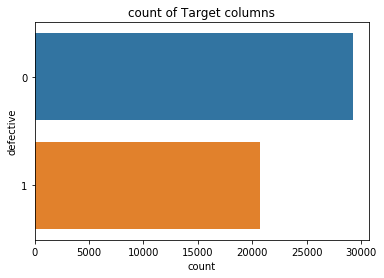

In [11]:
ax = sns.countplot( y = 'defective' , data=train_data);
ax.set_title('count of Target columns');

In [12]:
train_data['date_recorded'] = (pd.to_datetime(train_data['date_recorded'])).apply(lambda x: x.toordinal())

In [13]:
num_cols = list(set(train_data.columns) - set(train_data.select_dtypes(include=['object']).columns))
cat_cols = list(set(train_data.select_dtypes(include=['object']).columns) - set(['defective']))
print('length of numerical columns' , len(num_cols))
print('length of categorical columns' , len(cat_cols))

length of numerical columns 11
length of categorical columns 29


### Numerical columns

Let us look at the correlation value of Target column with numerical features. And correlation among those feature also.

In [14]:
'defective' in num_cols

True

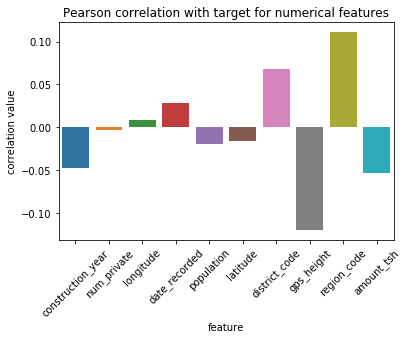

In [15]:
corr_df = train_data[num_cols].drop("defective", axis=1).apply(lambda x: x.corr(train_data.defective)).reset_index()
corr_df.columns = ['feature' , 'correlation value']


ax = sns.barplot(x=corr_df['feature'], y=corr_df['correlation value'])
ax.set_xticklabels(corr_df['feature'].values , rotation = 45);
ax.set_title('Pearson correlation with target for numerical features');


None of these features are highly correlated with Target feature.

among numerical features, 'district code' , 'gps height' and 'region code' are highly correlated with target variable. It indicates that geopgraphic location seems to have higher correlation and hence may be higher predictive power with target variable.

In [16]:
num_cols.remove('defective')
len(num_cols)

10

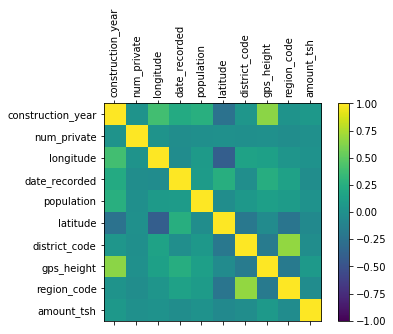

In [18]:
correlations = train_data[num_cols].corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, 10,1)

ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(num_cols, rotation = 90)
ax.set_yticklabels(num_cols)
plt.show()

The correlations among numerical columns have following insights:
1) columns for geopgraphical locations such as district code - region code are correlated.
2) Contruction year is correlated with longitude , gps height.

### Categorical columns

Some of the column names appear to be very similar. We may want to observe correlation among them. If the count of distribution is same and % target distribution is same , we can safely drop one of the two categorical feature.

In [28]:
pd.crosstab(train_data['quantity'] , train_data['quantity_group'])

quantity_group,dry,enough,insufficient,seasonal,unknown
quantity,,,,,
dry,5654,0,0,0,0
enough,0,27923,0,0,0
insufficient,0,0,12433,0,0
seasonal,0,0,0,3291,0
unknown,0,0,0,0,699


In [32]:
pd.crosstab(train_data['water_quality'] , train_data['quality_group'])

quality_group,colored,fluoride,good,milky,salty,unknown
water_quality,,,,,,
coloured,405,0,0,0,0,0
fluoride,0,170,0,0,0,0
fluoride abandoned,0,12,0,0,0,0
milky,0,0,0,733,0,0
salty,0,0,0,0,4222,0
salty abandoned,0,0,0,0,244,0
soft,0,0,42568,0,0,0
unknown,0,0,0,0,0,1646


In [36]:
pd.crosstab(train_data['payment'] , train_data['payment_type'])

payment_type,annually,monthly,never pay,on failure,other,per bucket,unknown
payment,,,,,,,
never pay,0,0,21287,0,0,0,0
other,0,0,0,0,861,0,0
pay annually,3065,0,0,0,0,0,0
pay monthly,0,6676,0,0,0,0,0
pay per bucket,0,0,0,0,0,7792,0
pay when scheme fails,0,0,0,3307,0,0,0
unknown,0,0,0,0,0,0,7012


In [34]:
pd.crosstab(train_data['waterpoint_type_group'] , train_data['waterpoint_type'])

waterpoint_type,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other
waterpoint_type_group,,,,,,,
cattle trough,106,0,0,0,0,0,0
communal standpipe,0,23838,4950,0,0,0,0
dam,0,0,0,5,0,0,0
hand pump,0,0,0,0,14958,0,0
improved spring,0,0,0,0,0,633,0
other,0,0,0,0,0,0,5510


In [35]:
pd.crosstab(train_data['extraction_type_group'] , train_data['extraction_type'])

extraction_type,afridev,cemo,climax,gravity,india mark ii,india mark iii,ksb,mono,nira/tanira,other,other - mkulima/shinyanga,other - play pump,other - rope pump,other - swn 81,submersible,swn 80,walimi,windmill
extraction_type_group,,,,,,,,,,,,,,,,,,
afridev,1604,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
gravity,0,0,0,21871,0,0,0,0,0,0,0,0,0,0,0,0,0,0
india mark ii,0,0,0,0,2079,0,0,0,0,0,0,0,0,0,0,0,0,0
india mark iii,0,0,0,0,0,89,0,0,0,0,0,0,0,0,0,0,0,0
mono,0,0,0,0,0,0,0,2480,0,0,0,0,0,0,0,0,0,0
nira/tanira,0,0,0,0,0,0,0,0,6836,0,0,0,0,0,0,0,0,0
other,0,0,0,0,0,0,0,0,0,5612,0,0,0,0,0,0,0,0
other handpump,0,0,0,0,0,0,0,0,0,0,2,75,0,203,0,0,36,0
other motorpump,0,74,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Drop scheme_name column and fill other missing columns with a new category NaN. 
Shortlist few features with small number of categories and look at theire distribution with respect to Target feature. 
If some catergorical feature is having changing distribution with respect to Target then it will have more predictive information.

In [19]:
cat_cols.remove('scheme_name')
len(cat_cols)

28

In [20]:
train_data[cat_cols] = train_data[cat_cols].fillna('NaN')

In [27]:
train_data[cat_cols].nunique().sort_values()[:12]

source_class             3
permit                   3
public_meeting           3
management_group         5
quantity                 5
quantity_group           5
waterpoint_type_group    6
quality_group            6
extraction_type_class    7
source_type              7
waterpoint_type          7
payment                  7
dtype: int64

In [22]:
train_data.drop(columns=['recorded_by'] , inplace=True)

In [23]:
cat_cols.remove('recorded_by')

In [24]:
sel_cat_cols = train_data[cat_cols].columns[train_data[cat_cols].nunique()<10].values.tolist()

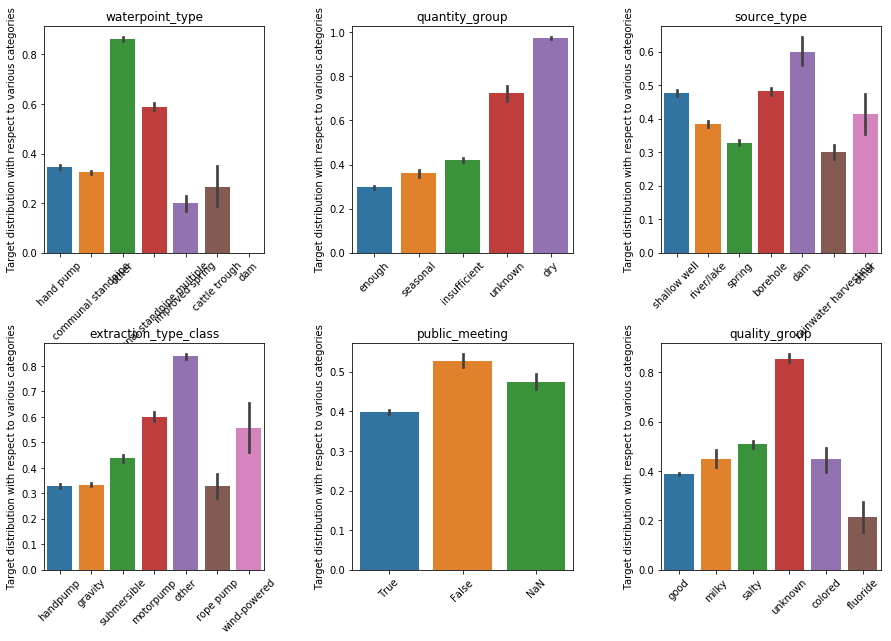

In [26]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 7):
    ax = fig.add_subplot(2, 3, i)
    g = sns.barplot(x = sel_cat_cols[i] , y ='defective' , data = train_data , ax=ax)
    for item in g.get_xticklabels():
        item.set_rotation(45)    
    ax.set_title(sel_cat_cols[i]);
    ax.set_xlabel('');
    ax.set_ylabel('Target distribution with respect to various categories');
   

From above charts we can understand that 5 features except public meeting have variation present with respect to different categories and hence these feature can be important for us.